In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.special import logit

import util


In [19]:
N = int(1e2)
n_i = np.tile(np.array([20, 20, 35, 35]), (N, 1))
y_i = np.tile(np.array([0, 1, 9, 10], dtype=np.float64), (N, 1))
data = np.stack((y_i, n_i), axis=2)
inla_model = INLA()

In [20]:
%%time
sigma2_post = inla_model.inference(y_i, n_i)

9
CPU times: user 7.02 ms, sys: 1.17 ms, total: 8.19 ms
Wall time: 7.28 ms


In [22]:
correct = np.array(
    [
        1.25954474e02,
        4.52520893e02,
        8.66625278e02,
        5.08333300e02,
        1.30365045e02,
        2.20403048e01,
        3.15183578e00,
        5.50967224e-01,
        2.68365061e-01,
        1.23585852e-01,
        1.13330444e-02,
        5.94800210e-04,
        4.01075571e-05,
        4.92782335e-06,
        1.41605356e-06,
    ]
)
np.testing.assert_allclose(sigma2_post[0], correct, rtol=1e-3)


In [8]:
import berry
import quadrature

arm_idx = 0
ti_N = 61
ti_rule = util.simpson_rule(ti_N, -6.0, 2.0)

b = berry.Berry()
integrate_dims = [0, 1, 2, 3]
integrate_dims.remove(arm_idx)
quad_p_ti_g_y = quadrature.integrate(
    b,
    data[
        :1,
    ],
    integrate_sigma2=True,
    integrate_thetas=integrate_dims,
    fixed_dims={arm_idx: ti_rule},
    n_theta=9,
)
quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts, axis=1)[:, None]


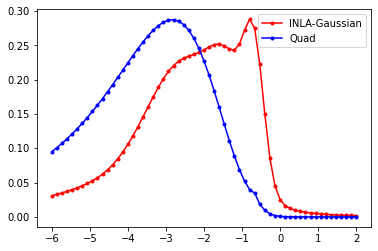

In [9]:
theta_i_sigma = np.sqrt(np.diagonal(-np.linalg.inv(hess[0]), axis1=1, axis2=2))
theta_i_mu = theta_max
gaussian_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    theta_i_mu[:1, :, arm_idx],
    theta_i_sigma[None, :, arm_idx],
)
gaussian_p_ti_g_y = np.sum(
    gaussian_pdf * sigma2_post[0] * sigma2_rule.wts[None, :], axis=1
)
plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "r-o", markersize=3, label="INLA-Gaussian")
plt.plot(ti_rule.pts, quad_p_ti_g_y[0], "b-o", markersize=3, label="Quad")
plt.legend()
plt.show()
